In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate

In [2]:
random_seed = 108
test_size = 0.2

In [3]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict_proba(X)[:,1]
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['f1_score'] = [f1_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba)]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

In [4]:
test_df = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})

In [5]:
df = pd.read_excel(io='AUSCOVID_DATA_2023-04-02_1133.xlsx')

In [6]:
# excluded efgr as derivative of creatinine
# 
cols = ['age','sex','healthcare_worker','hypertension',
        'hypercholesterolemia',
       'diabetes' ,'smoker','copd','asthma','ckd','dialysis','height','weight','sbp','dbp',
        'heart_rate','respiratory_rate','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous','chest_xray','vaccinated','pacemaker','troponin_uln',
         #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
        'coronary_med_history_col']

# get rid of past medical_history
# 'fio2','po2','pco2'

coronary_med_history_col = [
    'coronary_artery_disease',
    'heart_failure_cardiomyopathy',
    'af_flutter',
    'severe_valvular_disease',
    'stroke_tia',
    'pad']

cardio_complication = [
    'pericarditis',
    'new_2nd_degree_heart_block',
    'new_3rd_degree_heart_block',
    'conscious_sustained_vt',
    'new_cardiomyopathy_hf',
    'new_af_flutter',
    'myocarditis_myopericarditis',
    'pulm_embolus',
    'cardiac_arrest'
]

# replace No's to 0
for col in coronary_med_history_col + cardio_complication + ['past_medical_history']:
    df[col] = df[col].replace(2, 0)


df['death'] = [1 if x == 1 or x == 2 else 0 for x in df['discharge_status']]
df['vaccinated'] = [1 if x == 2 or x == 3 or  x == 4 else 0 for x in df['vaccination_status']]
df['pacemaker'] = [1 if x == 1 else 0 for x in df['ppm_icd']]
df['coronary_med_history_col'] = df[coronary_med_history_col].any(axis=1)


categorical_col = ['sex','healthcare_worker','hypertension',
        'hypercholesterolemia','diabetes', 'smoker','copd','asthma','ckd','dialysis',
                   'chest_xray','vaccinated','pacemaker','troponin_uln',
                     #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
             'coronary_med_history_col']



predictor = ['intubation_dummy','death','cardio_complication']

df['intubation_dummy'] =  [1 if x == 1 else 0 for x in df['intubation']]
df['cardio_complication'] = df[cardio_complication].any(axis=1).astype(float)


data_predictor = df[predictor]
data = df[cols+predictor]

In [7]:
float_col = ['height','sbp','dbp','heart_rate','weight','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous']
int_col = ['age']

In [8]:
data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_13556\935426440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)


In [9]:
df_dummy =  pd.get_dummies(
        data,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)

In [10]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df_dummy, test_size=test_size, random_state=random_seed)


In [11]:
df_dummy.shape

(1714, 41)

In [12]:
train.shape

(1371, 41)

In [13]:
test.shape

(343, 41)

In [14]:
predictor

['intubation_dummy', 'death', 'cardio_complication']

In [45]:
cont_describe = df[float_col+int_col].describe()

In [68]:
pd.DataFrame(df[float_col+int_col].isna().sum()).T/df.shape[0]*100

,height,sbp,dbp,heart_rate,weight,temperature,spo2,crp,lymphocytes,total_wcc,platelets,albumin,ldh,d_dimer,ferritin,haemoglobin,creatinine,alt,lactate_venous,age
0,64.177363,5.075846,8.809802,3.033839,50.875146,6.651109,8.051342,16.8028,5.017503,4.375729,4.900817,12.77713,51.866978,50.408401,54.259043,4.725788,4.609102,16.044341,56.067678,0.0


In [69]:
cont_describe = pd.concat([cont_describe,pd.DataFrame(df[float_col+int_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe.loc['NA_perc',:] = cont_describe.loc['NA',:]/df.shape[0]*100

In [73]:
cont_describe.T.to_csv("result/data/continuous_variable_summary.csv")

In [87]:
for c in categorical_col:
    df_sub = pd.concat([df[c].value_counts(dropna=False),df[c].value_counts(dropna=False,normalize=True)*100],axis=1).sort_index()
    df_sub.to_csv("result/data/" + c + "_summary.csv")

# Figures

In [15]:
model_dict = {
    'l1': 'l1_feature_selection_median_impute_oversample',
    'l2': 'l2_feature_selection_median_impute_oversample',
    #'EN': 'elasticnet_feature_selection_median_impute_oversample',
    'SVM' : 'svm_median_impute_feature_select_oversample',
    'DT': 'decision_feature_selection_median_impute_oversample',
    'RF': 'rf_selection_median_impute_final_oversample',
    'AB': 'adaboost_median_impute_feature_oversample',
    'GB': 'gradboost_median_impute_feature_oversample',
    
}

In [16]:
for p in predictor:
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        test_result_df = evaluate_model(test_pipe,X_test,y_test)
        test_result_df["outcome"] = p
        test_result_df["model"] = model_name

        test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [17]:
test_df.to_csv("result/final_outcome.csv")

In [23]:
test_df = pd.read_csv("result/final_outcome.csv",index_col=0)

In [30]:
best_result = test_df.sort_values('auc',ascending=False).groupby("outcome").head(1)

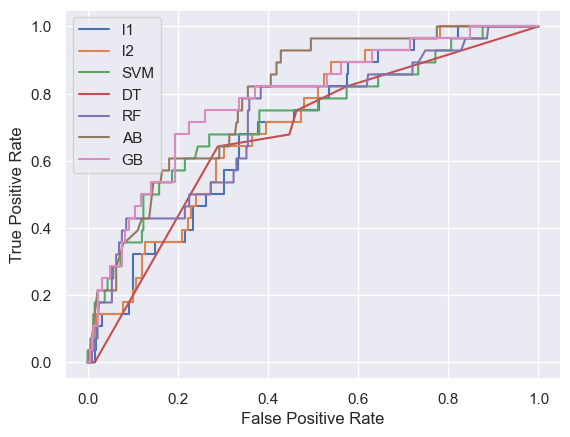

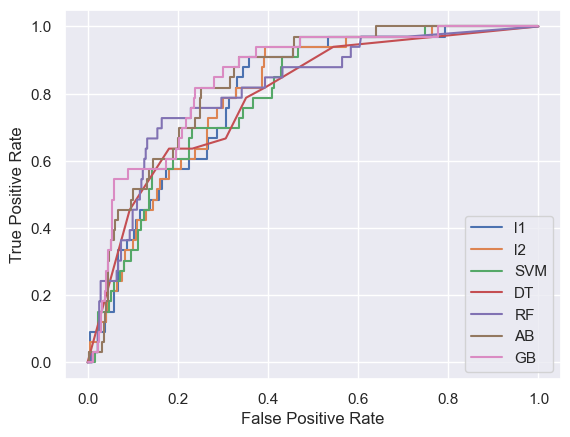

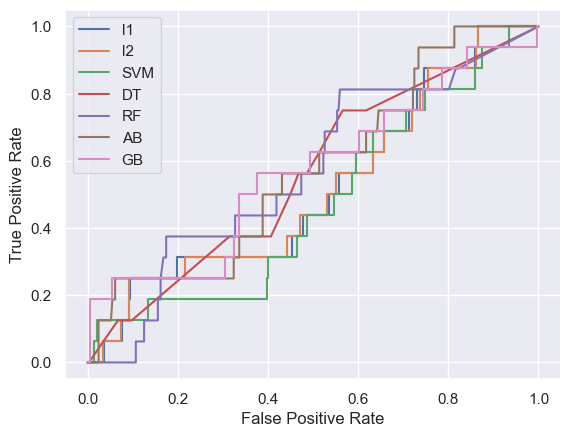

In [18]:
from sklearn import  metrics

for p in predictor:
    f, axs = plt.subplots(1, 1)
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    
    
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k,ax=axs) 
        if v in best_result[best_result["outcome"] == p]["model"].values:
            metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k)
    axs.legend(list(model_dict.keys()))
    axs.set_xlabel('False Positive Rate')
    axs.set_ylabel('True Positive Rate')
    plt.savefig("figure/auc_curves_" + p + ".png",bbox_inches="tight")

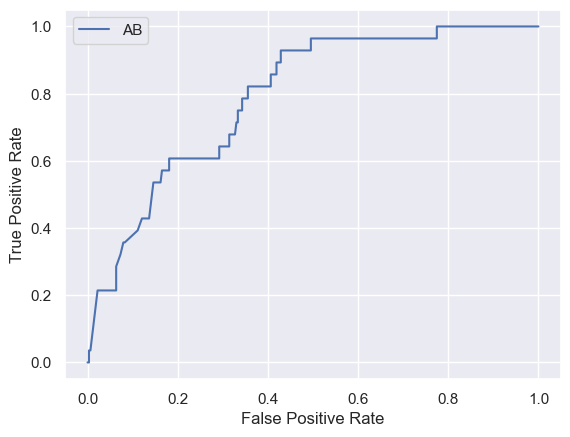

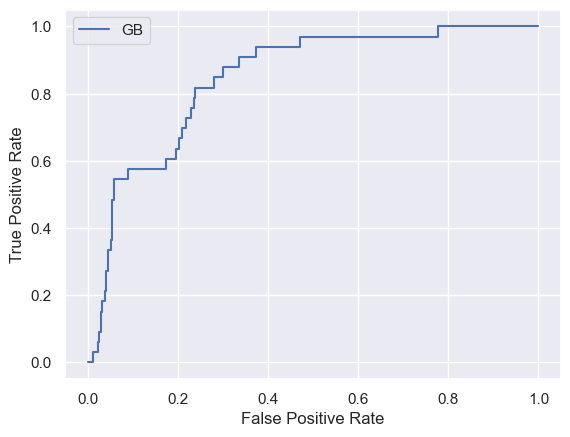

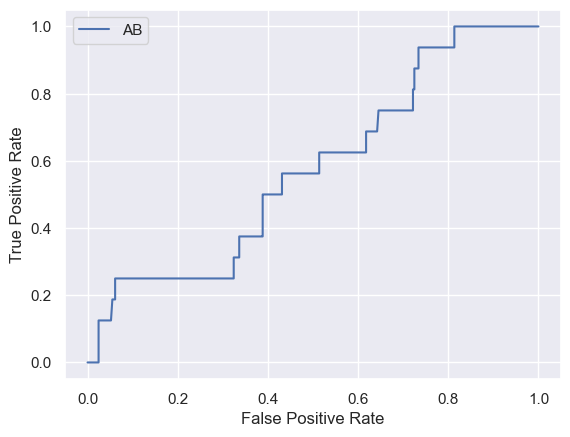

In [42]:
for p in predictor:
    
    y_test = test[p]
    X_test = test.drop(predictor, axis=1)
    
    for k,v in model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
        if v in best_result[best_result["outcome"] == p]["model"].values:
            f, axs = plt.subplots(1, 1)
            metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k,ax= axs)
            axs.legend([k])
            axs.set_xlabel('False Positive Rate')
            axs.set_ylabel('True Positive Rate')
            plt.savefig("figure/auc_curves_" + p + "_" + k + ".png",bbox_inches="tight")